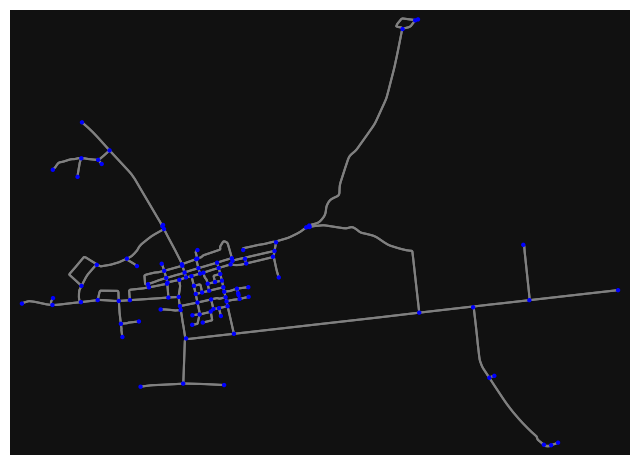

简化后的网络节点数: 110
简化后的网络边数: 276


In [110]:
import osmnx as ox
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import math
from shapely.geometry import Point

# 选择城市
place = "Schiermonnikoog, Netherlands"

# 获取交通网络（仅包含行车道路）
G = ox.graph_from_place(place, network_type="drive", simplify=True)

# 投影到米制坐标系
G_proj = ox.project_graph(G)

# 合并交叉路口并重建拓扑
# Gc = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)

# 确保所有边都有权重属性（例如长度）
for u, v, data in G.edges(data=True):
    if 'length' in data:
        data['weight'] = data['length']  # 使用长度作为权重
    else:
        data['weight'] = ox.distance.great_circle_vec(G.nodes[u]['y'], G.nodes[u]['x'], G.nodes[v]['y'], G.nodes[v]['x'])

# 删除不需要的边
edges_to_remove = []
for u, v, key, data in G.edges(keys=True, data=True):
    if u == v or 'weight' not in data:  # 自环边或没有权重属性的边
        edges_to_remove.append((u, v, key))

G.remove_edges_from(edges_to_remove)

# 绘制交通网络
fig, ax = ox.plot_graph(G, node_size=10, node_color='blue', edge_linewidth=1.5, edge_color='gray', show=False, close=False)
plt.show()

# 打印简化后的网络信息以便调试
print(f"简化后的网络节点数: {len(G.nodes())}")
print(f"简化后的网络边数: {len(G.edges())}")

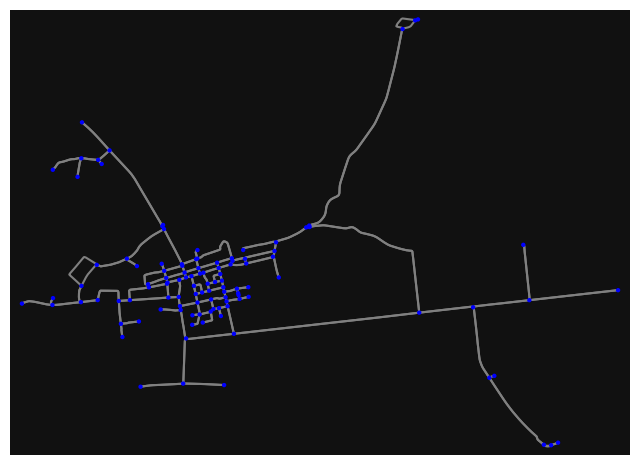

简化后的网络节点数: 110
简化后的网络边数: 270


In [111]:
# 删除所有平行边
edges_to_remove = []
for u, v, key in G.edges(keys=True):
    if u == v or key != 0:
        edges_to_remove.append((u, v, key))

G.remove_edges_from(edges_to_remove)
# 绘制交通网络
fig, ax = ox.plot_graph(G, node_size=10, node_color='blue', edge_linewidth=1.5, edge_color='gray', show=False, close=False)
plt.show()

# 打印简化后的网络信息以便调试
print(f"简化后的网络节点数: {len(G.nodes())}")
print(f"简化后的网络边数: {len(G.edges())}")

In [104]:
# 获取建筑信息
buildings = ox.features_from_place(place, tags={'building': True})
amenities = ox.features_from_place(place, tags={'amenity': True})

# 查看建筑的类型
building_types = buildings['building'].value_counts()
print("Building Types:\n", building_types)

# 查看设施的类型
amenity_types = amenities['amenity'].value_counts()
print("Amenity Types:\n", amenity_types)

# 打印建筑和设施信息以便调试
print(f"建筑数量: {len(buildings)}")
print(f"设施数量: {len(amenities)}")

# 打印 buildings 和 amenities 数据框的列名和前几行以便调试
print("Buildings DataFrame 预览：")
print(buildings.head())

print("Amenities DataFrame 预览：")
print(amenities.head())


Building Types:
 building
yes                   813
house                 463
bungalow              150
detached              106
shed                   76
apartments             32
industrial             26
bunker                 14
terrace                12
retail                 11
service                 8
hotel                   7
commercial              6
farm_auxiliary          5
construction            5
static_caravan          4
garage                  4
office                  3
school                  3
church                  3
civic                   2
hut                     2
sports_centre           2
government              2
fire_station            1
garages                 1
bus_garage              1
semidetached_house      1
toilets                 1
roof                    1
hospital                1
Name: count, dtype: int64
Amenity Types:
 amenity
bench                     63
bicycle_parking           37
restaurant                11
parking                    9
wa

In [112]:
# 定义设施类型ID映射
facility_id_map = {
    'house': 1,
    'school': 2,
    'industrial': 3,
    'bungalow': 4,
    'restaurant': 5,
    'retail': 6,
    'commercial': 7
}

# 提取设施类型并分配ID
def get_facility_id(row, source):
    if source == 'building':
        if row.get('building') in facility_id_map:
            return facility_id_map[row.get('building')]
    elif source == 'amenity':
        if row.get('amenity') in facility_id_map:
            return facility_id_map[row.get('amenity')]
    return 0

# 查找最近的交通网络节点
def find_nearest_node(G, point, radius):
    nodes_within_radius = [node for node, data in G.nodes(data=True)
                           if point.distance(Point(data['x'], data['y'])) <= radius]
    if nodes_within_radius:
        nearest_node = min(nodes_within_radius,
                           key=lambda node: point.distance(Point(G.nodes[node]['x'], G.nodes[node]['y'])))
        return nearest_node
    return None

# 初始化节点的设施数量统计
for node in G.nodes:
    G.nodes[node]['facility_count'] = {key: 0 for key in facility_id_map.values()}

# 标记建筑设施并统计数量
def assign_facilities_to_nodes(facilities, source):
    for idx, row in facilities.iterrows():
        facility_id = get_facility_id(row, source)
        if facility_id != 0:
            radius = 0.001  # 初始半径大约100米
            nearest_node = None
            while nearest_node is None and radius <= 0.01:  # 最大半径大约1公里
                nearest_node = find_nearest_node(G, row.geometry.centroid, radius)
                radius += 0.001
            if nearest_node:
                G.nodes[nearest_node]['facility_count'][facility_id] += 1

assign_facilities_to_nodes(buildings, 'building')
assign_facilities_to_nodes(amenities, 'amenity')

# 打印每个节点的设施数量
for node, data in G.nodes(data=True):
    print(f"Node {node} has facilities: {data['facility_count']}")


Node 48495581 has facilities: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Node 48495599 has facilities: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0}
Node 48495612 has facilities: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Node 48495669 has facilities: {1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Node 48495682 has facilities: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Node 48495909 has facilities: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Node 48495959 has facilities: {1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Node 48495975 has facilities: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Node 48496101 has facilities: {1: 0, 2: 0, 3: 4, 4: 0, 5: 0, 6: 0, 7: 0}
Node 48496135 has facilities: {1: 9, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Node 48496142 has facilities: {1: 0, 2: 0, 3: 4, 4: 0, 5: 0, 6: 0, 7: 0}
Node 48496228 has facilities: {1: 8, 2: 0, 3: 2, 4: 0, 5: 0, 6: 0, 7: 0}
Node 48496231 has facilities: {1: 4, 2: 0, 3: 2, 4: 0, 5: 0, 6: 0, 7: 0}
Node 48496241 has facilities: {1: 10, 2: 1, 3: 0, 4

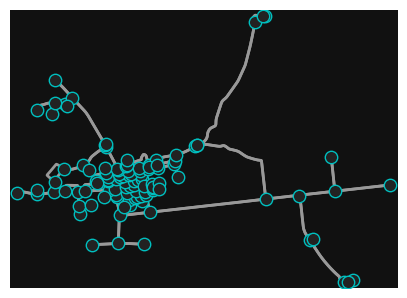

In [114]:
# 计算网络的中心点和边界框
c = ox.graph_to_gdfs(G, edges=False).unary_union.centroid
bbox = ox.utils_geo.bbox_from_point(point=(c.y, c.x), dist=200, project_utm=True)

# 绘制简化后的交通网络
fig, ax = ox.plot_graph(
    G,
    figsize=(5, 5),
    edge_linewidth=2,
    node_size=80,
    node_color="#222222",
    node_edgecolor="c",
)


In [115]:
nx.write_graphml(G, "traffic_network.graphml")

print("GraphML 文件已保存为 traffic_network.graphml")

NetworkXError: GraphML writer does not support <class 'dict'> as data values.